In [9]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np 

amountOfLocations = None
locations = []
cars = None
depot = (50, 50)  # This will place the depot in the center of the grid

generations = 50
population_size = 15
mutation_rate = 0.3
crossover_probability = 0.6

In [10]:
def generate_locations(n, bounds=(0,100), seed=None):
    if seed is not None:
        rnd = random.Random(seed)
        return [(rnd.randint(bounds[0], bounds[1]), rnd.randint(bounds[0], bounds[1])) for _ in range(n)]
    return [(random.randint(bounds[0], bounds[1]), random.randint(bounds[0], bounds[1])) for _ in range(n)]

def make_scenarios(seed=None):
    s = 0 if seed is None else seed
    return [
        {"id":"small-1", "num_vehicles":3,  "num_customers":12, "customers": generate_locations(12, seed=s+1)},
        {"id":"small-2", "num_vehicles":7,  "num_customers":18, "customers": generate_locations(18, seed=s+2)},
        {"id":"medium-1","num_vehicles":11, "num_customers":20, "customers": generate_locations(20, seed=s+3)},
        {"id":"medium-2","num_vehicles":15, "num_customers":28, "customers": generate_locations(28, seed=s+4)},
        {"id":"large-1", "num_vehicles":26, "num_customers":30, "customers": generate_locations(30, seed=s+5)},
        {"id":"large-2", "num_vehicles":30, "num_customers":40, "customers": generate_locations(38, seed=s+6)},
    ]

In [11]:
if not locations:
    if amountOfLocations is None:
        amountOfLocations = 50   # fallback default
    locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(amountOfLocations)]

def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def applay_scenario(scenario):
    global amountOfLocations, locations, cars, depot, dist_matrix, dist_to_depot  # //audit - added distance cache globals
    amountOfLocations = scenario["num_customers"]
    locations = scenario["customers"][:]
    cars = scenario["num_vehicles"]
    depot = scenario.get("depot", (0,0))
    
    # //audit - precompute all distances once per scenario
    n = len(locations)
    dist_matrix = np.zeros((n, n))  # //audit - numpy array for faster access
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = distance(locations[i], locations[j])
    dist_to_depot = np.array([distance(depot, locations[i]) for i in range(n)]) 

def get_vrp_cost_and_routes(individual, num_vehicles):
    n = len(individual) #pop size????????
    if n == 0:
        return float('inf'), []
    
    # //audit - use precomputed distance matrix instead of computing on the fly
    try:
        dm = dist_matrix
        dtd = dist_to_depot
        dist_seq = [dm[individual[i]][individual[(i+1) % n]] for i in range(n)]
    except NameError:
        # fallback if distance matrix not available
        dist_seq = [distance(locations[individual[i]], locations[individual[(i+1) % n]]) for i in range(n)]
        dtd = None
    
    # //audit - use numpy for prefix sum (faster)
    prefix = np.zeros(n + 1)
    prefix[1:] = np.cumsum(dist_seq)
    
    inf = float('inf')
    # //audit - use numpy arrays for DP tables (faster memory access)
    dp = np.full((num_vehicles + 1, n + 1), inf)
    prev = np.full((num_vehicles + 1, n + 1), -1, dtype=int)
    dp[0][0] = 0
   
    for m in range(1, num_vehicles + 1):
        for j in range(1, n + 1):
            for i in range(j):
                if j - i < 1:  # No empty routes
                    continue
                internal = prefix[j] - prefix[i]
                start_idx = individual[i]
                end_idx = individual[j-1]
                
                # //audit - use precomputed distances if available
                if dtd is not None:
                    route_cost = dtd[start_idx] + internal + dtd[end_idx]
                else:
                    route_cost = distance(depot, locations[start_idx]) + internal + distance(locations[end_idx], depot)
                
                new_cost = dp[m-1][i] + route_cost
                if new_cost < dp[m][j]:
                    dp[m][j] = new_cost
                    prev[m][j] = i
    
    total_distance = dp[num_vehicles][n]
    if total_distance == inf:
        return inf, []
    # Reconstruct routes (unchanged)
    routes = []
    m = num_vehicles
    j = n
    while j > 0:
        i = prev[m][j]
        if i == -1:
            return inf, []
        route = individual[i:j]
        routes.append(route)
        j = i
        m -= 1
    routes.reverse()
    return total_distance, routes


def fitness(individual):
    total_dist, _ = get_vrp_cost_and_routes(individual, cars)
    return 1 / total_dist if total_dist > 0 else 0

def create_individual():
    return random.sample(range(len(locations)), len(locations))

def crossover(parent1, parent2):
    if random.random() < crossover_probability:
        start, end = sorted(random.sample(range(len(parent1)), 2))
        child = [-1] * len(parent1)
        child[start:end] = parent1[start:end]
        # //audit - use set for O(1) membership test instead of O(n) list search
        visited = set(child[start:end])
        pointer = end
        for location in parent2:
            if location not in visited:  # //audit - much faster than 'not in child'
                child[pointer] = location
                visited.add(location)  # //audit - keep set updated
                pointer = (pointer + 1) % len(child)
        return child
    else:
        return parent1[:] if random.random() < 0.5 else parent2[:]


def mutate(individual):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def tournament_selection(fitnesses,k=3):
    indices = random.sample(range(len(fitnesses)), k)
    return max(indices, key=lambda i: fitnesses[i])

def visualize_individual(individual, fitness_value):
    total_dist, routes = get_vrp_cost_and_routes(individual, cars)
    route_str = "\n".join([f"Vehicle {r+1}: depot -> " + " -> ".join(map(str, route)) + " -> depot" for r, route in enumerate(routes)])
    return f"{route_str}\nTotal Distance: {total_dist:.2f} Fitness: {fitness_value:.6f}"

def genetic_algorithm_with_tracking():
    population = [create_individual() for _ in range(population_size)]
    best_fitness_per_gen = []
    elite_size = 1
    
    # //audit - compute fitnesses once per generation, reuse
    fitnesses = [fitness(ind) for ind in population]
    
    for generation in range(generations):
        best_fitness = max(fitnesses)
        best_fitness_per_gen.append(best_fitness)
        
        # //audit - use precomputed fitnesses for sorting
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        elites = [population[i][:] for i in sorted_indices[:elite_size]]
        
        new_population = []
        # Generate offspring using index-based selection
        for _ in range((population_size - elite_size) // 2):
            p1_idx = tournament_selection(fitnesses, k=3)  # //audit - use index-based selection
            p2_idx = tournament_selection(fitnesses, k=3)
            parent1 = population[p1_idx]
            parent2 = population[p2_idx]
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        
        new_population.extend(elites)
        
        # //audit - handle odd population sizes
        while len(new_population) < population_size:
            new_population.append(elites[0][:])
        
        population = new_population[:population_size]  # //audit - ensure exact size
        # //audit - recompute fitnesses only once per generation
        fitnesses = [fitness(ind) for ind in population]
    
    return best_fitness_per_gen


=== SUMMARY BY GROUP ===
Group    ParamSet     Scenario           Best          Avg        Worst   Time(s)
---------------------------------------------------------------------------------
Small    Conservative small-1        0.001400     0.001364     0.001325      0.06
Small    Conservative small-2        0.000941     0.000909     0.000880      0.30
Small    Balanced     small-1        0.001435     0.001417     0.001380      0.16
Small    Balanced     small-2        0.000989     0.000973     0.000954      0.74
---------------------------------------------------------------------------------
Medium   Conservative medium-1       0.000578     0.000557     0.000541      0.56
Medium   Conservative medium-2       0.000384     0.000380     0.000378      1.49
Medium   Balanced     medium-1       0.000637     0.000620     0.000599      1.40
---------------------------------------------------------------------------------
Large    Conservative large-1        0.000231     0.000227     0.000219 

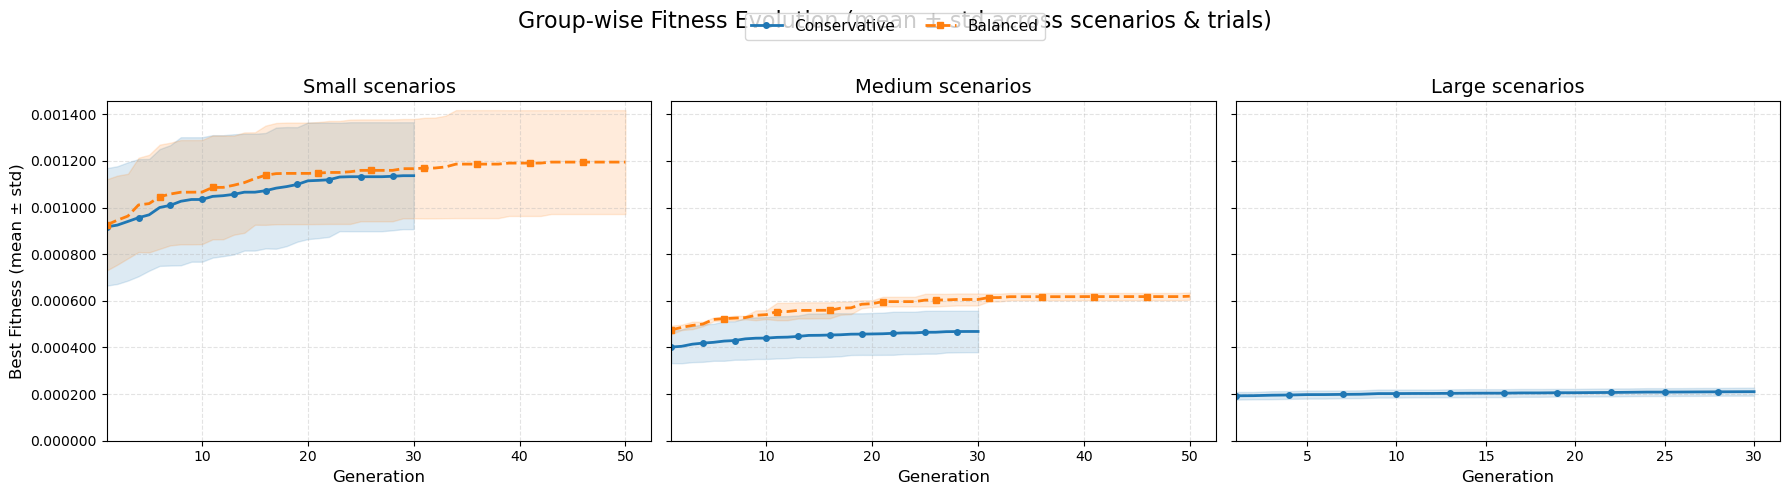

In [12]:
# 🌽🌽 FAST TEST 🌽🌽
# Cleaned single cell: group summary + readable group plots (no duplicates)

if 'parameter_sets' not in globals():
    parameter_sets = [
        {"name":"Conservative","generations":30,"population_size":10,"mutation_rate":0.1,"crossover_probability":0.6},
        {"name":"Balanced","generations":50,"population_size":15,"mutation_rate":0.3,"crossover_probability":0.8},
        {"name":"Aggressive","generations":70,"population_size":20,"mutation_rate":0.5,"crossover_probability":0.9},
    ]

# sanity guards if results not present (don't crash)
if 'all_results' not in globals() or not isinstance(all_results, dict):
    print("Warning: all_results not found — run experiments first to populate results.")
    all_results = {}

if 'timing_results' not in globals() or not isinstance(timing_results, dict):
    timing_results = {}

# Groups and visuals
groups = {
    "Small": ["small-1", "small-2"],
    "Medium": ["medium-1", "medium-2"],
    "Large": ["large-1", "large-2"],
}

param_colors = {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'}
param_linestyles = {'Conservative': '-', 'Balanced': '--', 'Aggressive': ':'}
param_markers = {'Conservative': 'o', 'Balanced': 's', 'Aggressive': '^'}

# Print nicely aligned summary by group (mirrors run output)
print("\n=== SUMMARY BY GROUP ===")
header = f"{'Group':8} {'ParamSet':12} {'Scenario':10} {'Best':>12} {'Avg':>12} {'Worst':>12} {'Time(s)':>9}"
print(header)
print("-" * len(header))
for gname, sids in groups.items():
    for p in parameter_sets:
        pname = p['name']
        for sid in sids:
            vals = all_results.get(pname, {}).get(sid)
            if vals:
                t = timing_results.get(pname, {}).get(sid, {}).get('avg_time', 0.0)
                print(f"{gname:8} {pname:12} {sid:10} {vals['best']:12.6f} {vals['avg']:12.6f} {vals['worst']:12.6f} {t:9.2f}")
    print("-" * len(header))

# Group-wise plots: mean ± std across scenarios and trials
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
plt.subplots_adjust(wspace=0.25)

for ax, (gname, sids) in zip(axs, groups.items()):
    ax.set_title(f"{gname} scenarios", fontsize=14)
    ax.set_xlabel("Generation", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.35)

    for p in parameter_sets:
        pname = p['name']
        gens = p['generations']
        stacked = []
        for sid in sids:
            entry = all_results.get(pname, {}).get(sid)
            if not entry:
                continue
            trials = entry.get('trials', [])
            if not trials:
                continue
            arr = np.array(trials)
            if arr.size == 0:
                continue
            # normalize/truncate/pad to parameter set generations
            if arr.shape[1] > gens:
                arr = arr[:, :gens]
            elif arr.shape[1] < gens:
                pad = np.tile(arr[:, -1:], (1, gens - arr.shape[1]))
                arr = np.concatenate([arr, pad], axis=1)
            stacked.append(arr)

        if not stacked:
            continue
        all_trials = np.vstack(stacked)  # shape (total_trials, gens)
        mean_per_gen = np.mean(all_trials, axis=0)
        std_per_gen = np.std(all_trials, axis=0)
        gens_range = np.arange(1, len(mean_per_gen) + 1)

        ax.plot(gens_range, mean_per_gen, label=pname,
                color=param_colors.get(pname), linestyle=param_linestyles.get(pname), linewidth=2,
                marker=param_markers.get(pname), markersize=4, markevery=max(1, len(gens_range)//10))
        ax.fill_between(gens_range, mean_per_gen - std_per_gen, mean_per_gen + std_per_gen,
                        color=param_colors.get(pname), alpha=0.15)

    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("")  # shared ylabel set below
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.6f}"))

# shared labels/legend/title
axs[0].set_ylabel("Best Fitness (mean ± std)", fontsize=12)
handles, labels = axs[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.99),
               ncol=min(len(parameter_sets), 4), fontsize=11)
fig.suptitle("Group-wise Fitness Evolution (mean ± std across scenarios & trials)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

In [ ]:
if 'parameter_sets' not in globals():
    parameter_sets = [
        {"name":"Conservative","generations":30,"population_size":10,"mutation_rate":0.1,"crossover_probability":0.6},
        {"name":"Balanced","generations":50,"population_size":15,"mutation_rate":0.3,"crossover_probability":0.8},
        {"name":"Aggressive","generations":70,"population_size":20,"mutation_rate":0.5,"crossover_probability":0.9},
    ]

scenarios = make_scenarios(seed=42)
all_results = {}
timing_results = {}  # //audit - added timing tracking
num_trials = 3

for params in parameter_sets:
    generations = params["generations"]
    population_size = params["population_size"]
    mutation_rate = params["mutation_rate"]
    crossover_probability = params["crossover_probability"]

    print(f"\n=== PARAM SET: {params['name']} (G={generations} P={population_size} M={mutation_rate} X={crossover_probability}) ===")
    all_results[params['name']] = {}
    timing_results[params['name']] = {}

    for scenario in scenarios:
        print(f"\nRunning scenario: {scenario['id']}  Vehicles: {scenario['num_vehicles']}, Customers: {scenario['num_customers']}")
        applay_scenario(scenario)

        trial_results = []
        final_fitnesses = []
        trial_times = []  # //audit - track time per trial

        for trial in range(num_trials):
            print(f"  Trial {trial+1}/{num_trials}...", end="", flush=True)
            
            # //audit - time the genetic algorithm run
            start_time = time.time()
            best_fitness_per_gen = genetic_algorithm_with_tracking()
            end_time = time.time()
            trial_time = end_time - start_time
            
            trial_results.append(best_fitness_per_gen)
            final_fitnesses.append(best_fitness_per_gen[-1])
            trial_times.append(trial_time)
            print(f" done ({trial_time:.2f}s)")

        # //audit - compute statistics including timing
        final_fitnesses_np = np.array(final_fitnesses)
        trial_times_np = np.array(trial_times)
        
        best_final = float(np.max(final_fitnesses_np))
        worst_final = float(np.min(final_fitnesses_np))
        avg_final = float(np.mean(final_fitnesses_np))
        std_final = float(np.std(final_fitnesses_np))
        
        avg_time = float(np.mean(trial_times_np))
        std_time = float(np.std(trial_times_np))

        all_results[params['name']][scenario['id']] = {
            'trials': trial_results,
            'final_fitnesses': final_fitnesses,
            'best': best_final,
            'worst': worst_final,
            'avg': avg_final,
            'std': std_final
        }
        
        timing_results[params['name']][scenario['id']] = {
            'avg_time': avg_time,
            'std_time': std_time,
            'trial_times': trial_times
        }

        print(f"  Best: {best_final:.6f}  Avg: {avg_final:.6f} ± {std_final:.6f}  Time: {avg_time:.2f}s ± {std_time:.2f}s")

# //audit - TIMING SUMMARY TABLE
print("\n=== TIMING SUMMARY TABLE ===")
print("ParamSet    Scenario    Avg Time(s)  Std Time(s)")
for p_name, scen_dict in timing_results.items():
    for sid, timing in scen_dict.items():
        print(f"{p_name:11} {sid:10} {timing['avg_time']:11.2f} {timing['std_time']:11.2f}")

# //audit - PERFORMANCE SUMMARY TABLE (Best, Avg, Worst from multiple runs)
print("\n=== PERFORMANCE SUMMARY TABLE ===")
print("ParamSet    Scenario    Best Fitness  Avg Fitness   Worst Fitness  Std")
for p_name, scdict in all_results.items():
    for sid, vals in scdict.items():
        print(f"{p_name:11} {sid:10} {vals['best']:12.6f} {vals['avg']:12.6f} {vals['worst']:13.6f} {vals['std']:9.6f}")

# //audit - SINGLE COMPARISON GRAPH: All 6 scenarios with 3 parameter sets
print("\n=== GENERATING UNIFIED COMPARISON GRAPH ===")
plt.figure(figsize=(15, 10))

# Colors for scenarios and styles for parameter sets
scenario_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
param_styles = {'Conservative': '-', 'Balanced': '--', 'Aggressive': ':'}
param_markers = {'Conservative': 'o', 'Balanced': 's', 'Aggressive': '^'}

for p_idx, params in enumerate(parameter_sets):
    generations = params["generations"]
    
    for s_idx, scenario in enumerate(scenarios):
        # //audit - use stored results instead of re-running
        if scenario['id'] in all_results[params['name']]:
            trial_results = all_results[params['name']][scenario['id']]['trials']
            trial_results_np = np.array(trial_results)
            avg_fitness_per_gen = np.mean(trial_results_np, axis=0)
            
            plt.plot(range(1, generations+1), avg_fitness_per_gen,
                     color=scenario_colors[s_idx], 
                     linestyle=param_styles[params['name']],
                     marker=param_markers[params['name']],
                     markersize=4, markevery=max(1, generations//10),
                     label=f"{scenario['id']} - {params['name']}", 
                     linewidth=2)

plt.xlabel('Generation', fontsize=12)
plt.ylabel('Best Fitness (Average across trials)', fontsize=12)
plt.title('Fitness Evolution: All Scenarios vs All Parameter Sets', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()